## Wines Quality ML Model

##### data from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

Data Set Information:

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.


Attribute Information:

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

In [1]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import yellowbrick as yb
from yellowbrick.features import RadViz
from yellowbrick.model_selection import LearningCurve



import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
#Read the data from csv
wines_red = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                       sep=';')
wines_white = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                       sep=';')

print("wines_red shape: ",wines_red.shape)
print("wines_white shape: ",wines_white.shape)

wines_red shape:  (1599, 12)
wines_white shape:  (4898, 12)


In [4]:
wines_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wines_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Continued with White Wines only

### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
Not overly insightful for our model. 

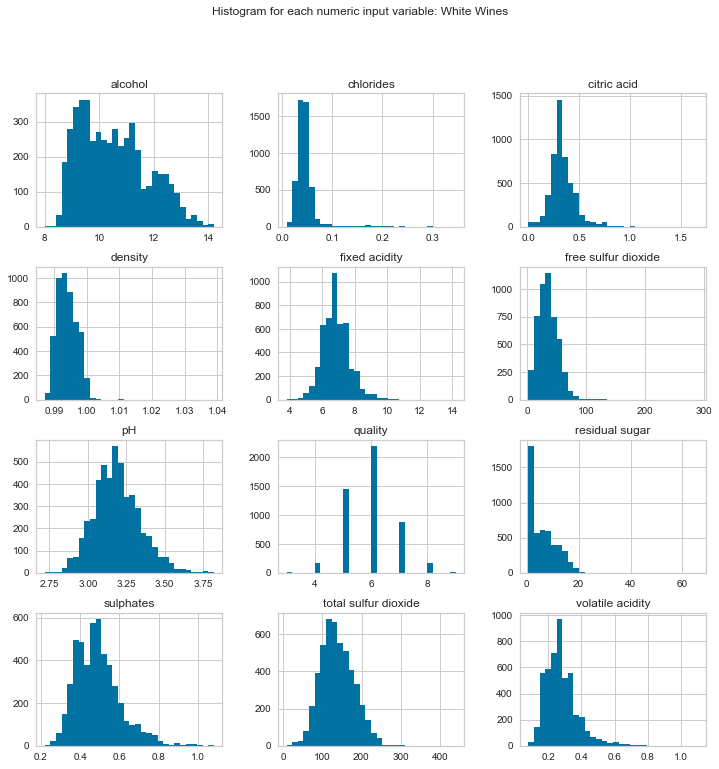

In [6]:
#historgram of all numerical data
wines_white.hist(bins=30, figsize=(12,12))
pl.suptitle("Histogram for each numeric input variable: White Wines")
plt.show()

### Set X, y for deeper feature evaluation

In [8]:
#feature we will go with
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

X = wines_white[feature_names]
y = wines_white['quality']

### Visualize the multicolinearity of features

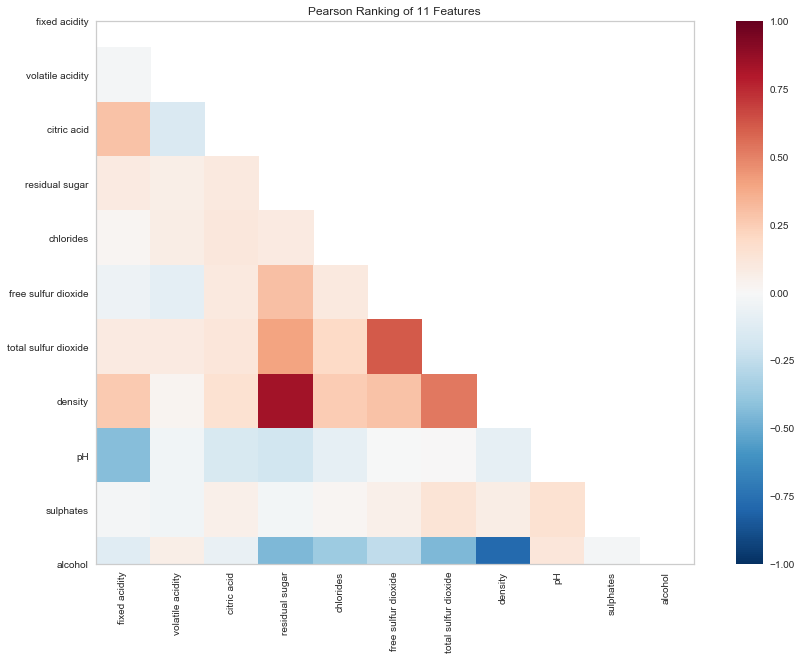

In [9]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

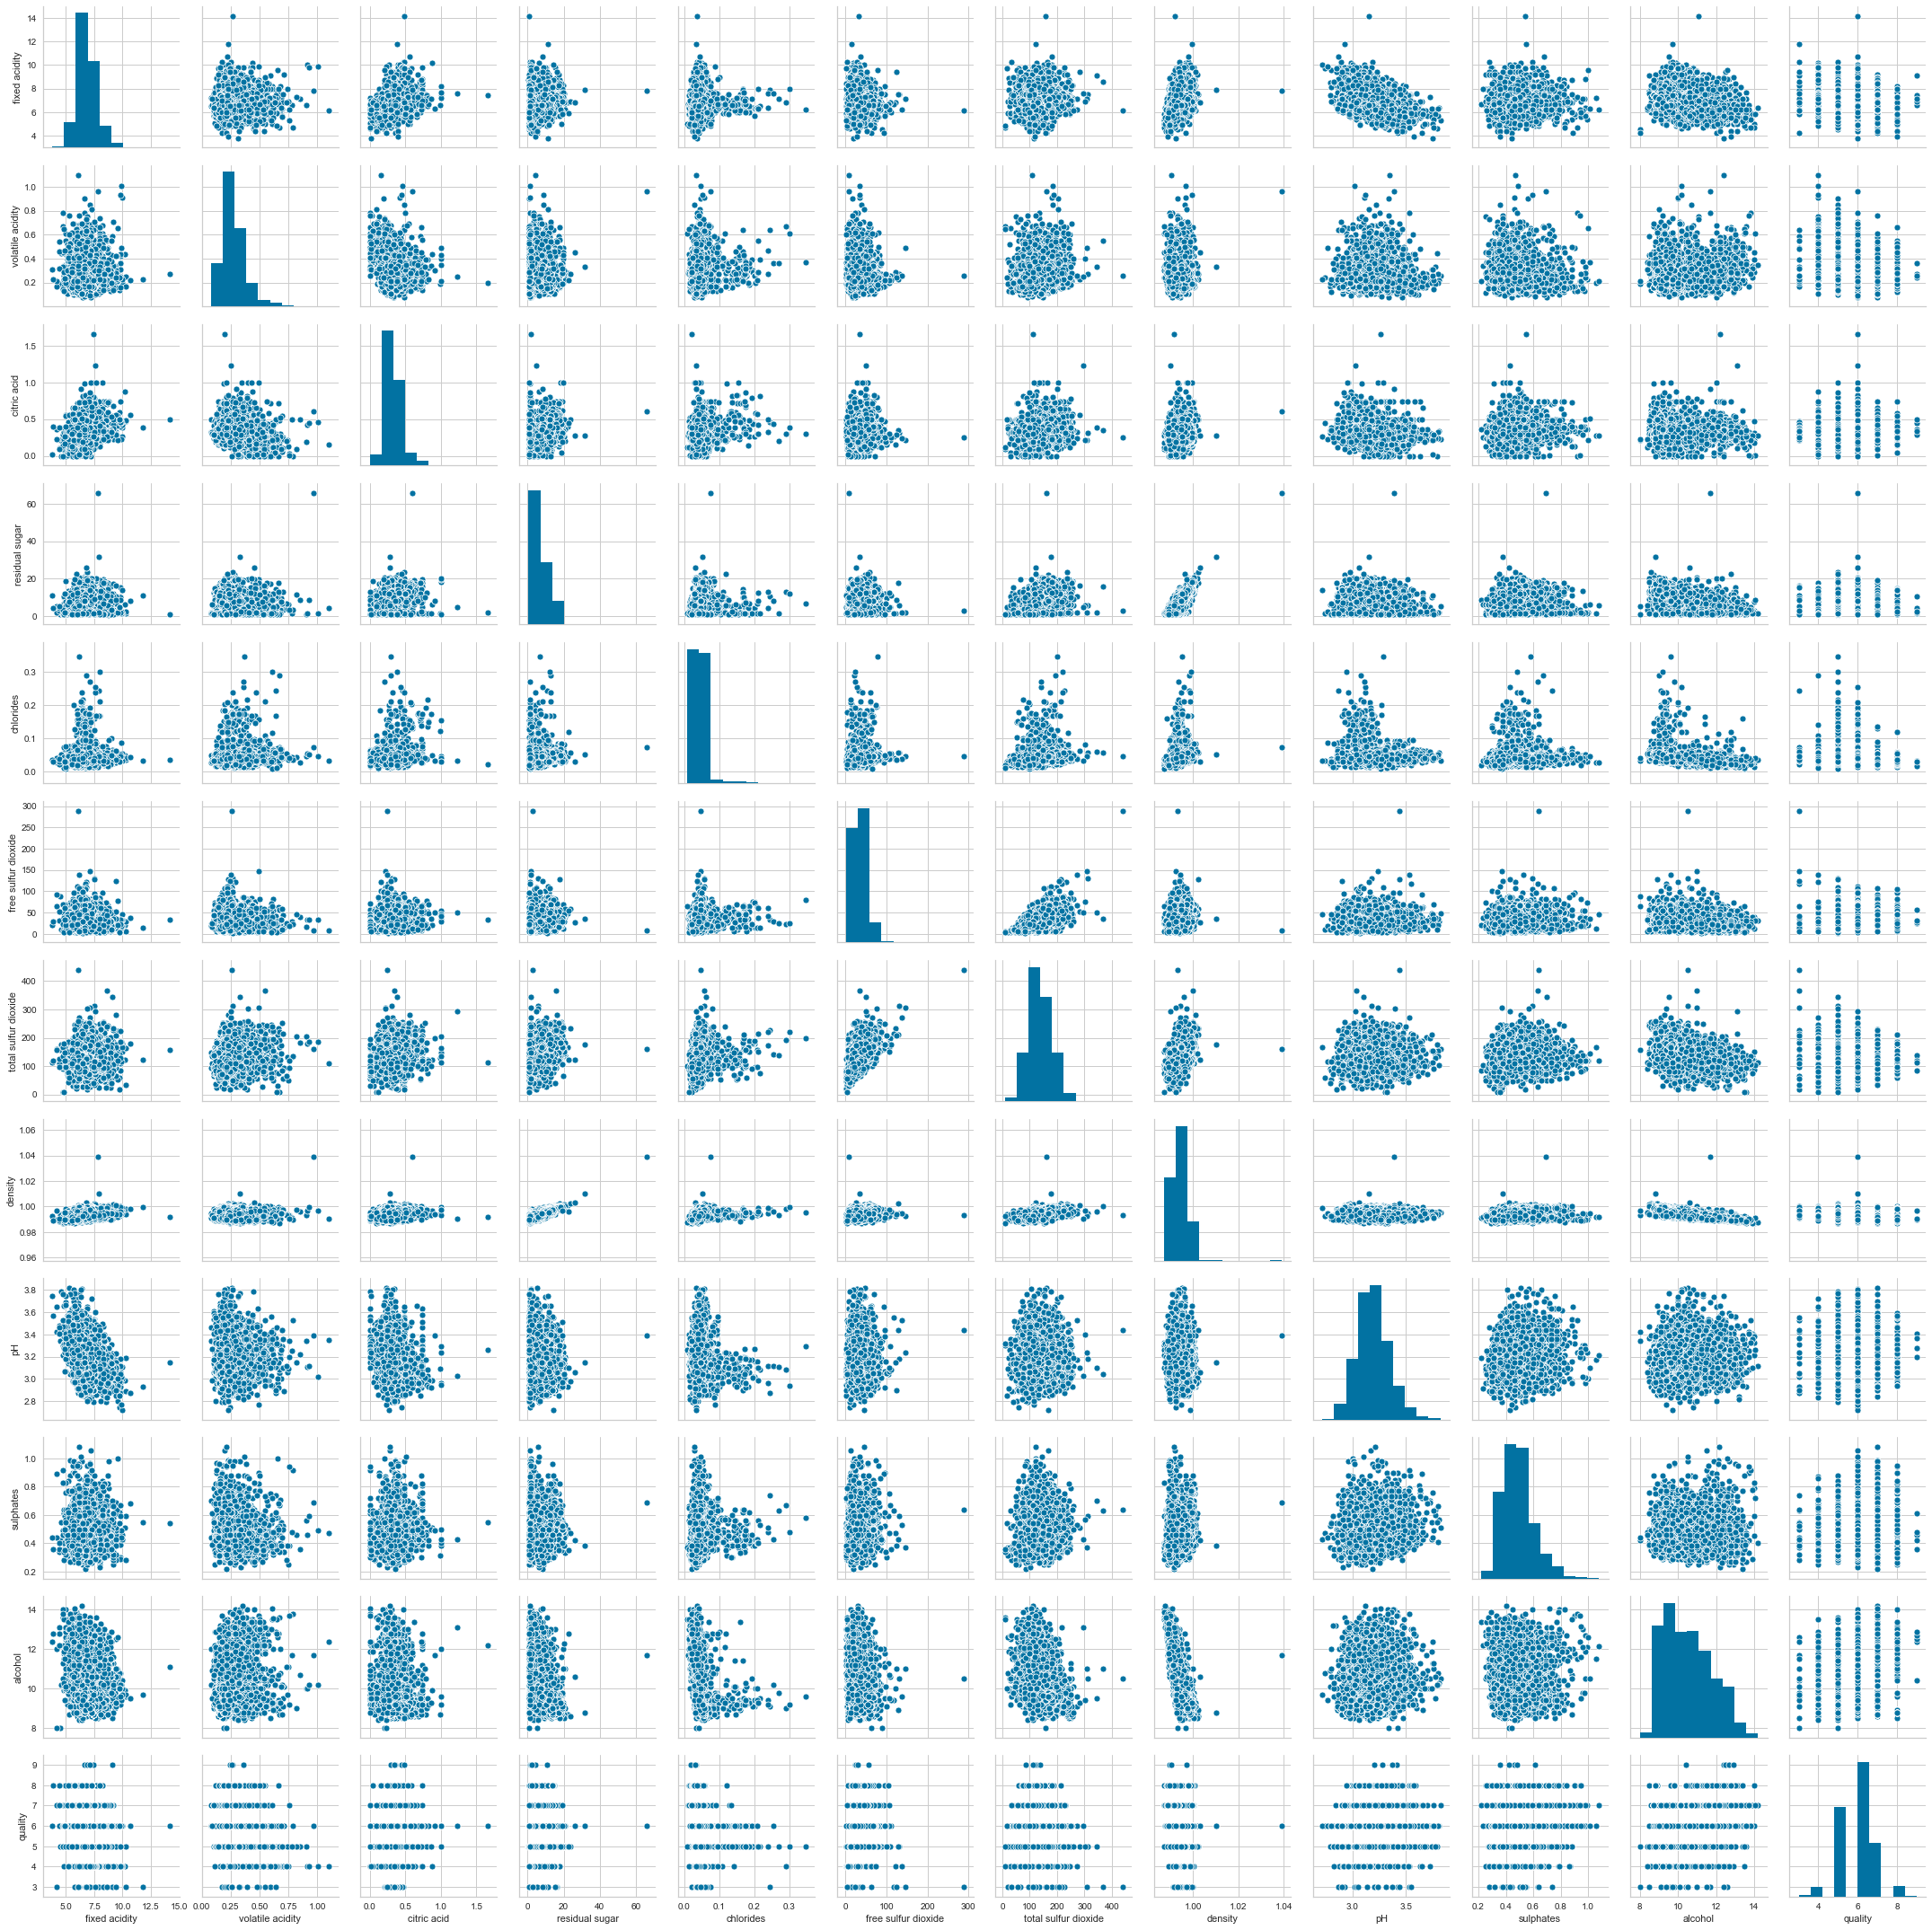

In [11]:
sns.pairplot(wines_white)

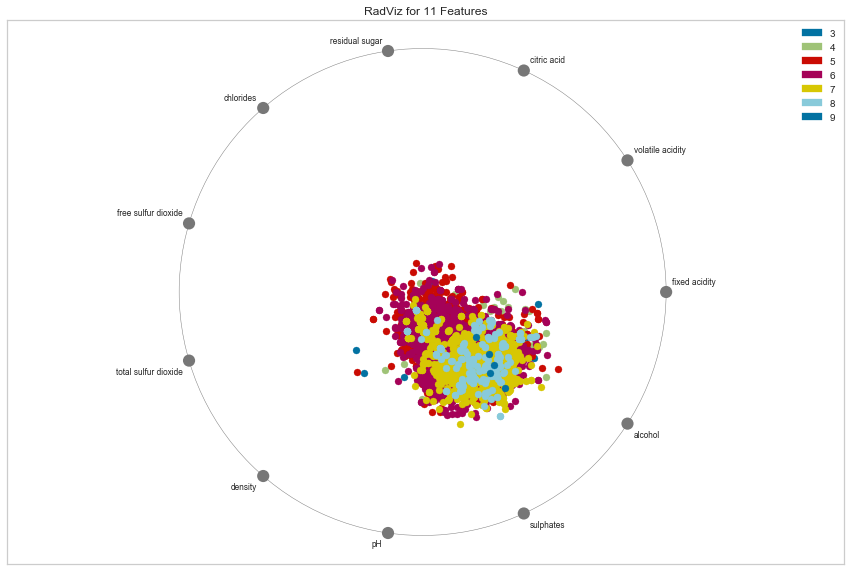

In [12]:
# Instantiate the visualizer
visualizer = RadViz(features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

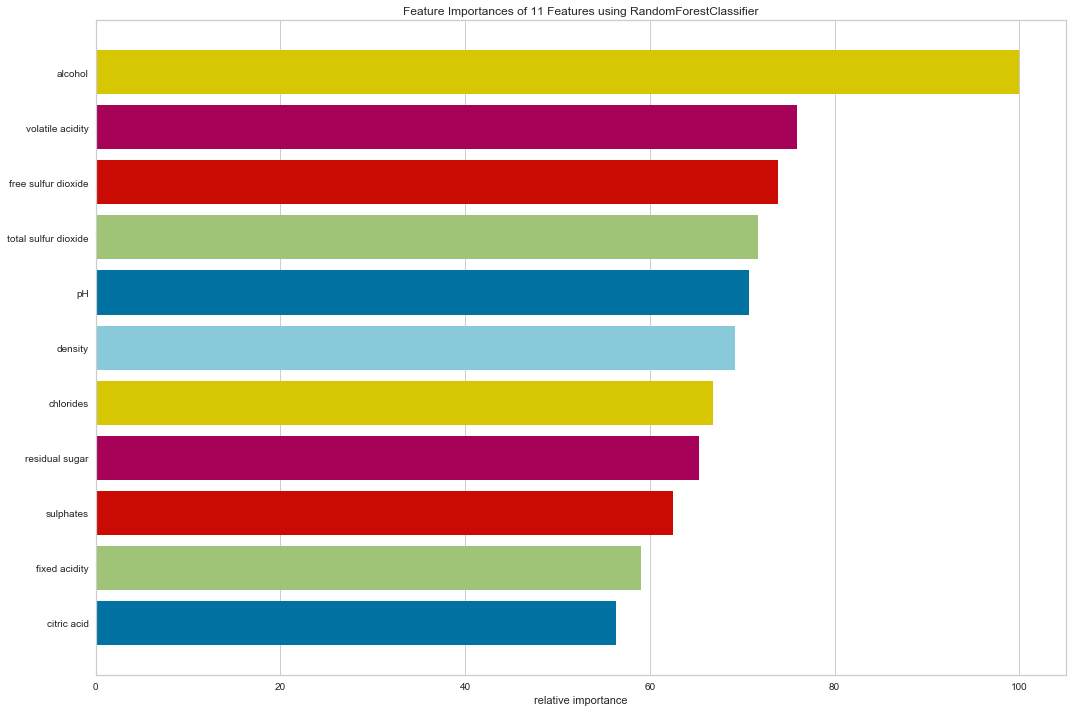

In [13]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=5)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
viz.show()

## Drop Density since it is coorelated with multiple columns

In [14]:
#final features
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
       'pH', 'sulphates', 'alcohol']

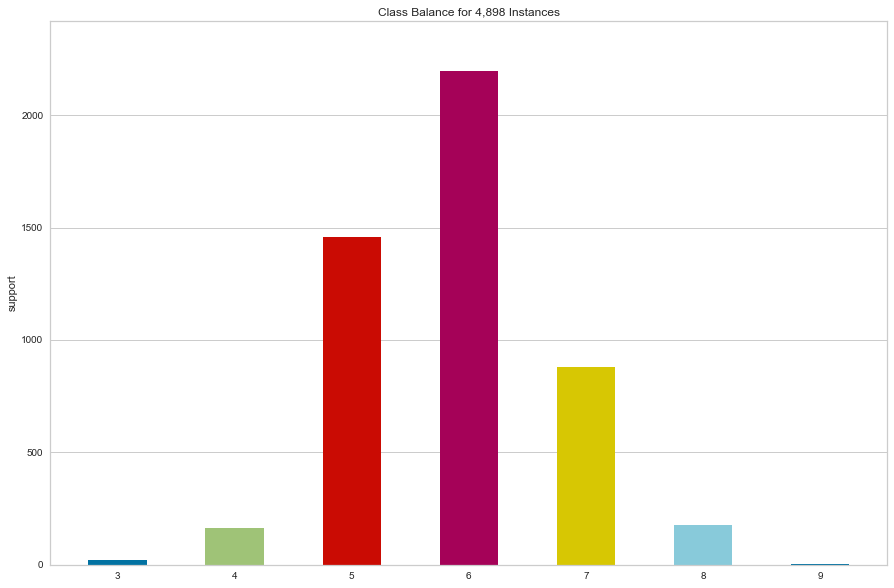

In [15]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance( size=(1080, 720)) 

visualizer.fit(y)
visualizer.show()

### See how well the models learns with linear SVC

In [16]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.3, 1.0, 10)

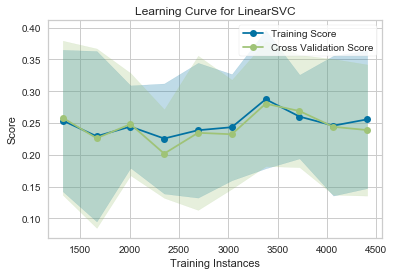

In [17]:
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

X
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()               



### Setup Pipeline to estimate
3000 samples seems to be a good training point.
The instances seem to drive the scores. Smaller classes perform poorly on precision and recall. 



In [18]:
# Create the train and test data
X= X[feature_names]
X_train, X_test, y_train, y_test = tts(X, y, train_size=3000)


pipe = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median')), ('LinearSVC()', LinearSVC(max_iter = 2000))])

pipe.fit(X_train, y_train)


#testing against note smote dataset
expected = y_test
predicted = pipe.predict(X_test)

print(classification_report(expected, predicted))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        50
           5       0.56      0.53      0.54       555
           6       0.52      0.79      0.63       879
           7       0.53      0.06      0.11       346
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1898
   macro avg       0.23      0.20      0.18      1898
weighted avg       0.50      0.53      0.47      1898



### Try RandomForest
Slightly better with precision and on lower number of instances.

In [19]:
# Create the train and test data
X= X[feature_names]
X_train, X_test, y_train, y_test = tts(X, y, train_size=3000)


pipe = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median')), ('RandomForestClassifier()', RandomForestClassifier(n_estimators=10))])

pipe.fit(X_train, y_train)


#testing against note smote dataset
expected = y_test
predicted = pipe.predict(X_test)

print(classification_report(expected, predicted))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.39      0.18      0.25        61
           5       0.62      0.70      0.66       564
           6       0.65      0.72      0.68       862
           7       0.66      0.49      0.57       337
           8       0.84      0.40      0.54        65
           9       0.00      0.00      0.00         1

    accuracy                           0.64      1898
   macro avg       0.45      0.36      0.38      1898
weighted avg       0.64      0.64      0.63      1898



In [ ]:
# Create the train and test data
X= X[feature_names]
X_train, X_test, y_train, y_test = tts(X, y, train_size=3000)


pipe = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median')), ('RandomForestClassifier()', RandomForestClassifier(n_estimators=10))])

pipe.fit(X_train, y_train)


#testing against note smote dataset
expected = y_test
predicted = pipe.predict(X_test)

print(classification_report(expected, predicted))
